In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import string
import re
from unidecode import unidecode
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
data = pd.read_csv('IMDB_Dataset_Part_1.csv')

# 1. Data preprocessing and Exploratory data analysis (EDA)

In [4]:
data.columns = ['review', 'sentiment']
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
# Found that there were <br /><br /> tags in the original data. Clean them here.
data['review'] = data['review'].str.replace('<br /><br />', ' ')

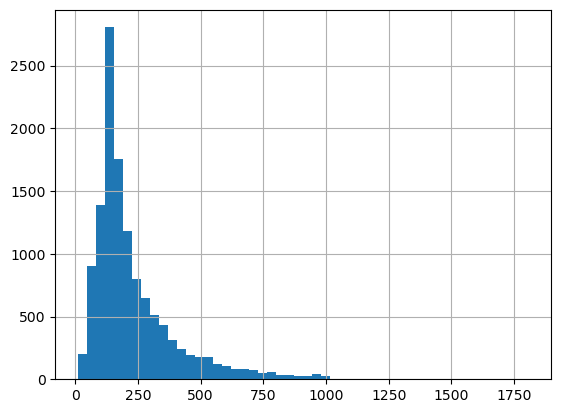

In [7]:
# Before moving forward to further processing, visualize the length of these comments. 
data['review_length'] = data['review'].apply(lambda x: len(x.split()))
data['review_length'].hist(bins=50)
plt.show()

# The length of the reviews is quite varied. We can see that most of the reviews are between 0 and 500 words long.
# The range that had the most reviews was between 0 and 100 words, with the peak at around 50 words.

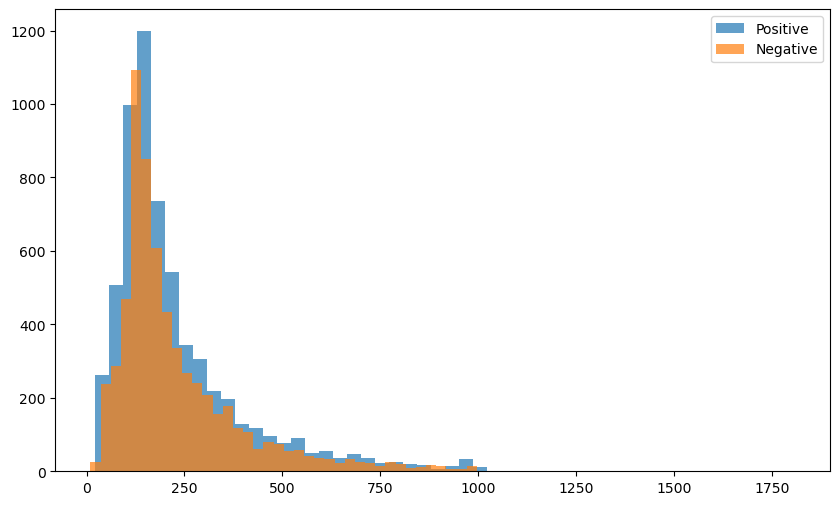

In [8]:
# Positive and negative length patterns are mostly similar, with negative ones shorter on average and having a smaller peak.
plt.figure(figsize=(10, 6))
plt.hist(data[data['sentiment'] == 1]['review_length'], bins=50, alpha=0.7, label='Positive')
plt.hist(data[data['sentiment'] == 0]['review_length'], bins=50, alpha=0.7, label='Negative')
plt.legend()
plt.show()

In [9]:
# The text had special letters like ó, which are not English. Convert them to English letters.
data['review'] = data['review'].apply(lambda x: unidecode(x))

# Use regular expressions to remove punctuations, but keep those single quotes that are part of a word, e.g., I'm, they're
# Doing this to fit in the stopword list
data['review'] = data['review'].apply(lambda x: re.sub(r"(?!\b\w+'\w+\b)[^\w\s]", '', x))

# Lowercase all the words
data['review'] = data['review'].apply(lambda x: x.lower())


In [10]:
# POS tagging
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    word_pos = pos_tag(word_tokenize(sentence))
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in word_pos])

data['review'] = data['review'].apply(lambda x: lemmatize_sentence(x))


In [11]:
# See what are the stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'same', 'again', 'as', 'no', 'll', "you'd", 'ours', "aren't", 'himself', 'their', 'wouldn', 'is', 'are', 'in', 'about', "you're", 'off', 'they', 'shouldn', 'over', "shouldn't", 'yours', "you'll", 'herself', 'but', 'who', 'so', 'its', 'i', 'it', "shan't", 'at', 'our', "needn't", 'she', 'an', 'through', 'hers', 'a', 'myself', 'will', 'don', 'we', 'doing', 'do', 'such', 'against', "doesn't", 'o', 'my', 'how', 'some', 'than', 'then', 'which', 'to', "weren't", 'both', 'hasn', 'for', "isn't", 'if', "wasn't", 'hadn', "hadn't", "mightn't", 'these', 'themselves', 'itself', "that'll", 'theirs', 'am', 'and', 'while', 'doesn', 't', 'was', 'after', 's', 'couldn', 'each', 'have', "hasn't", 'his', "you've", 'down', 've', 'above', 'won', "didn't", 'of', 'during', 'more', 're', 'isn', 'before', 'other', 'has', "couldn't", 'not', 'been', 'didn', 'just', 'on', 'from', 'with', 'needn', 'aren', 'yourself', 'why', 'own', 'the', 'be', "it's", 'until', 'below', "haven't", 'what', 'your', 'shan', "don't", 'me

In [12]:
# Customize the stop word list, because some appear too frequently in the reviews, indicating that they are not informational
stop_words.update(['movie', 'film', 'one', 'even', 'story', 'much', 'people', 'also', 'see', 'watch', 'look', 'make', 'go', 'would', 'think'])
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [13]:
data.to_csv('IMDB_Dataset_Part_1_processed.csv', index=False)

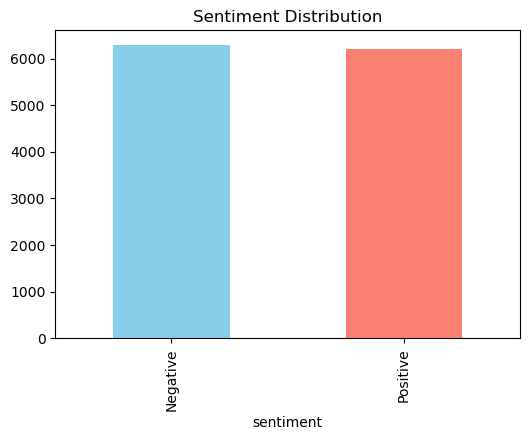

In [14]:
# Visualize the distribution of the two sentiments
plt.figure(figsize=(6, 4))
data['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Sentiment Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# From this chart, we can roughly know that the proportion of positive and negative data is rather balanced.

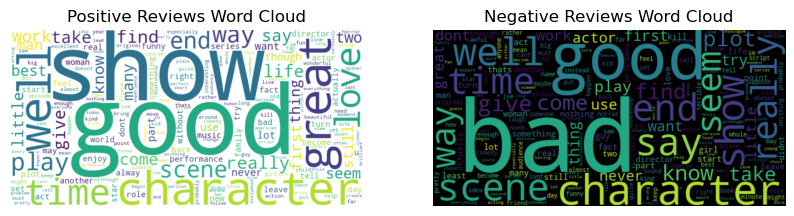

In [15]:
# Draw the word cloud for positive and negative reviews, unigram
positive_reviews = ' '.join(data[data['sentiment'] == 1]['review']) 
negative_reviews = ' '.join(data[data['sentiment'] == 0]['review'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white', random_state=43).generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', random_state=43).generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Reviews Word Cloud")
plt.axis('off')
plt.subplot(1, 2, 2) 
plt.imshow(wordcloud_neg, interpolation='bilinear') 
plt.title("Negative Reviews Word Cloud")
plt.axis('off')
plt.show()

# The unigram word cloud didn't provide much insights.

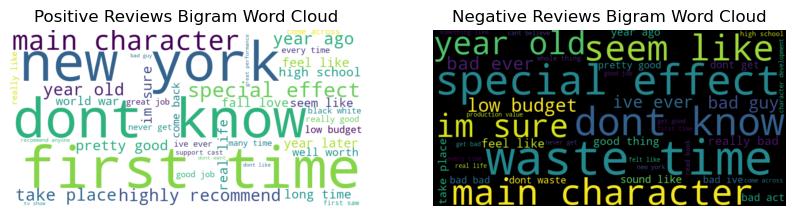

In [16]:
# Since the unigram word cloud didn't show much meaningful results, try bigram word cloud.
positive_reviews = ' '.join(data[data['sentiment'] == 1]['review'])
negative_reviews = ' '.join(data[data['sentiment'] == 0]['review'])

bigram_vectorizer_pos = CountVectorizer(ngram_range=(2, 2))
bigram_vectorizer_pos.fit(data[data['sentiment'] == 1]['review'])
bigram_words_pos = bigram_vectorizer_pos.transform(data[data['sentiment'] == 1]['review'])
sum_bigram_words_pos = bigram_words_pos.sum(axis=0)
bigram_words_freq_pos = [(word, sum_bigram_words_pos[0, idx]) for word, idx in bigram_vectorizer_pos.vocabulary_.items()]
bigram_words_freq_pos = sorted(bigram_words_freq_pos, key = lambda x: x[1], reverse=True)

bigram_vectorizer_neg = CountVectorizer(ngram_range=(2, 2))
bigram_vectorizer_neg.fit(data[data['sentiment'] == 0]['review'])
bigram_words_neg = bigram_vectorizer_neg.transform(data[data['sentiment'] == 0]['review'])
sum_bigram_words_neg = bigram_words_neg.sum(axis=0)
bigram_words_freq_neg = [(word, sum_bigram_words_neg[0, idx]) for word, idx in bigram_vectorizer_neg.vocabulary_.items()]
bigram_words_freq_neg = sorted(bigram_words_freq_neg, key = lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(bigram_words_freq_pos[:40]))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Reviews Bigram Word Cloud")
plt.axis('off')
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(dict(bigram_words_freq_neg[:40]))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Reviews Bigram Word Cloud")
plt.axis('off')
plt.show()

# The bigram word cloud reflects people's focus and emotions more obviously.

# 2. Preparation for Model Training

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import numpy as np

In [19]:
# Data spliting
X = data['review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [20]:
# Feature Engineering by TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [21]:
# Feature Engineering by Word2Vec
X_train_tokens = [review.split() for review in X_train]
X_test_tokens = [review.split() for review in X_test]

word2vec = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vector_size):
    feature_vector = np.zeros(vector_size, dtype='float32')
    num_words = 0
    for word in words:
        if word in model.wv.key_to_index:
            feature_vector = np.add(feature_vector, model.wv[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

X_train_w2v = np.array([average_word_vectors(tokens, word2vec, 100) for tokens in X_train_tokens])
X_test_w2v = np.array([average_word_vectors(tokens, word2vec, 100) for tokens in X_test_tokens])

# 3. Model training and evaluation

Three models were tried using two feature engineering methods (TF-IDF, Word2Vec): logistic regression, SVM and naive Bayes.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


In [24]:
# Logistic regression using features extracted from TF-IDF
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_lr = lr_tfidf.predict(X_test_tfidf)
print("Accuracy of Logistic Regression with TF-IDF:", accuracy_score(y_test, y_pred_tfidf_lr))

# Logistic regression using features extracted from Word2Vec
lr_w2v = LogisticRegression()
lr_w2v.fit(X_train_w2v, y_train)
y_pred_w2v_lr = lr_w2v.predict(X_test_w2v)
print("Accuracy of Logistic Regression with Word2Vec", accuracy_score(y_test, y_pred_w2v_lr))

Accuracy of Logistic Regression with TF-IDF: 0.8792
Accuracy of Logistic Regression with Word2Vec 0.8104


In [25]:
# # Try to improve the model accuracy by adjusting the Learning rate
# learning_rates = [0.001, 0.01, 0.1]
# results = []

# for lr in learning_rates:
#     print(f"Learning Rate = {lr}")

#     # Logistic Regression with TF-IDF
#     sgd_tfidf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=lr, random_state=43, max_iter=1000)
#     sgd_tfidf.fit(X_train_tfidf, y_train)
#     y_pred_tfidf = sgd_tfidf.predict(X_test_tfidf)
#     acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
#     print(f"TF-IDF Accuracy: {acc_tfidf}")

#     # Logistic Regression with Word2Vec
#     sgd_w2v = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=lr, random_state=43, max_iter=1000)
#     sgd_w2v.fit(X_train_w2v, y_train)
#     y_pred_w2v = sgd_w2v.predict(X_test_w2v)
#     acc_w2v = accuracy_score(y_test, y_pred_w2v)
#     print(f"Word2Vec Accuracy: {acc_w2v}")

#     results.append({
#         'Learning Rate': lr,
#         'Accuracy_TF-IDF': acc_tfidf,
#         'Accuracy_Word2Vec': acc_w2v})

In [26]:
# SVM using features extracted from TF-IDF
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_svm = svm_tfidf.predict(X_test_tfidf)
print("Accuracy of SVM with TF-IDF:", accuracy_score(y_test, y_pred_tfidf_svm))

# SVM using features extracted from Word2Vec
svm_w2v = SVC()
svm_w2v.fit(X_train_w2v, y_train)
y_pred_w2v_svm = svm_w2v.predict(X_test_w2v)
print("Accuracy of SVM with Word2Vec:", accuracy_score(y_test, y_pred_w2v_svm))

Accuracy of SVM with TF-IDF: 0.8812
Accuracy of SVM with Word2Vec: 0.8084


In [27]:
# # Try to improve the model accuracy by adjusting the C value (tradeoff parameter between error and margin)
# C_values = [0.1, 1, 10, 30]
# results = []

# for C in C_values:
#     print(f"C = {C}")
    
#     # SVM with TF-IDF
#     svm_tfidf = SVC(C=C, kernel='rbf', random_state=43)
#     svm_tfidf.fit(X_train_tfidf, y_train)
#     y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
#     accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
#     print(f"TF-IDF Accuracy: {accuracy_tfidf}")
    
#     # SVM with Word2Vec
#     svm_w2v = SVC(C=C, kernel='rbf', random_state=43)
#     svm_w2v.fit(X_train_w2v, y_train)
#     y_pred_w2v = svm_w2v.predict(X_test_w2v)
#     accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
#     print(f"Word2Vec Accuracy: {accuracy_w2v}")
    
#     results.append({
#         'C': C,
#         'Accuracy_TF-IDF': accuracy_tfidf,
#         'Accuracy_Word2Vec': accuracy_w2v })

In [28]:
# Naive bayes using features extracted from TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf)
print("Accuracy of Naive Bayes with TF-IDF:", accuracy_score(y_test, y_pred_tfidf_nb))

Accuracy of Naive Bayes with TF-IDF: 0.8556


In [29]:
# Performance evaluation with accuracy, precision, recall and F1 score
results = []
models = {
    "Logistic Regression TF-IDF": (y_test, y_pred_tfidf_lr),
    "Logistic Regression Word2Vec": (y_test, y_pred_w2v_lr),
    "SVM TF-IDF": (y_test, y_pred_tfidf_svm),
    "SVM Word2Vec": (y_test, y_pred_w2v_svm),
    "Naive Bayes TF-IDF": (y_test, y_pred_tfidf_nb)}

for model_name, (y_true, y_pred) in models.items():
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name}:  Accuracy: {accuracy:.2f}  Precision: {precision:.2f}  Recall: {recall:.2f}  F1 Score: {f1:.2f}\nConfusion Matrix:\n{cm}\n")
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1})

Logistic Regression TF-IDF:  Accuracy: 0.88  Precision: 0.87  Recall: 0.89  F1 Score: 0.88
Confusion Matrix:
[[1091  171]
 [ 131 1107]]

Logistic Regression Word2Vec:  Accuracy: 0.81  Precision: 0.79  Recall: 0.84  F1 Score: 0.82
Confusion Matrix:
[[ 980  282]
 [ 192 1046]]

SVM TF-IDF:  Accuracy: 0.88  Precision: 0.87  Recall: 0.90  F1 Score: 0.88
Confusion Matrix:
[[1094  168]
 [ 129 1109]]

SVM Word2Vec:  Accuracy: 0.81  Precision: 0.79  Recall: 0.84  F1 Score: 0.81
Confusion Matrix:
[[ 978  284]
 [ 195 1043]]

Naive Bayes TF-IDF:  Accuracy: 0.86  Precision: 0.85  Recall: 0.86  F1 Score: 0.85
Confusion Matrix:
[[1079  183]
 [ 178 1060]]



In [30]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression TF-IDF,0.8792,0.866197,0.894184,0.879968
1,Logistic Regression Word2Vec,0.8104,0.787651,0.844911,0.815277
2,SVM TF-IDF,0.8812,0.868442,0.895800,0.881909
3,SVM Word2Vec,0.8084,0.785983,0.842488,0.813255
4,Naive Bayes TF-IDF,0.8556,0.852776,0.856220,0.854494


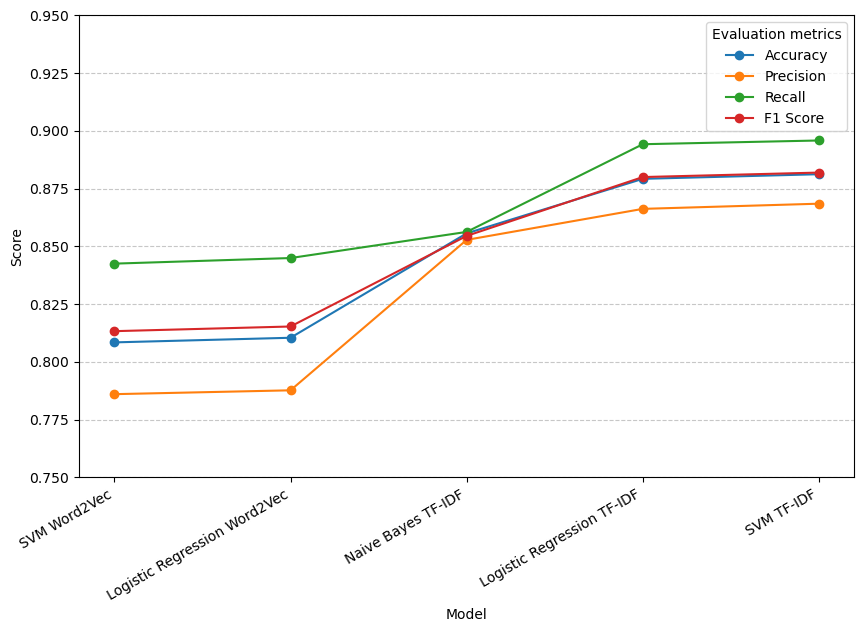

In [31]:
# Visualizing the results
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df_sorted = results_df.sort_values(by='F1 Score', ascending=True)
for metric in metrics:
    plt.plot(results_df_sorted['Model'], results_df_sorted[metric], marker='o', label=metric)

plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=30, ha='right')
plt.legend(title="Evaluation metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.75, 0.95)
plt.show()

In [32]:
# Define a function to predict the label of the input sentence
def test_model_predictions(test_sentence):
    models = {
        "Logistic Regression TF-IDF": lr_tfidf,
        "Logistic Regression Word2Vec": lr_w2v,
        "SVM TF-IDF": svm_tfidf,
        "SVM Word2Vec": svm_w2v,
        "Naive Bayes TF-IDF": nb_tfidf}     

    print("Test review:", test_sentence)
    
    test_sentence_tfidf = tfidf.transform([test_sentence])
    test_sentence_tokens = test_sentence.split()
    test_sentence_w2v = average_word_vectors(test_sentence_tokens, word2vec, 100).reshape(1, -1)
    
    predictions = {}
    
    for model_name, model in models.items():
        if "TF-IDF" in model_name:
            prediction = model.predict(test_sentence_tfidf)[0]
        elif "Word2Vec" in model_name:
            prediction = model.predict(test_sentence_w2v)[0]
        
        sentiment = "Positive" if prediction == 1 else "Negative"
        predictions[model_name] = sentiment
    
    return predictions

In [33]:
# Test the model with direct positive sentence
test_sentence_1 = "This film is an absolute masterpiece; every moment was good and beautifully crafted!"
# Use positive but semantically implicit sentence to test predictions
test_sentence_2 = "Its imagery weaves an elusive brilliance that seems to reach somewhere deep, leaving a resonance both haunting and curiously undefinable."
# Test the model with direct negative sentence
test_sentence_3 = "This movie was boring and a waste of time."
# Use negative but semantically implicit sentence to test predictions
test_sentence_4 = "An intriguing experiment in patience, where each scene seemed determined to outlast the viewer's attention span."


In [34]:
test_model_predictions(test_sentence_1)

Test review: This film is an absolute masterpiece; every moment was good and beautifully crafted!


{'Logistic Regression TF-IDF': 'Positive',
 'Logistic Regression Word2Vec': 'Positive',
 'SVM TF-IDF': 'Positive',
 'SVM Word2Vec': 'Positive',
 'Naive Bayes TF-IDF': 'Positive'}

In [35]:
test_model_predictions(test_sentence_2)

Test review: Its imagery weaves an elusive brilliance that seems to reach somewhere deep, leaving a resonance both haunting and curiously undefinable.


{'Logistic Regression TF-IDF': 'Positive',
 'Logistic Regression Word2Vec': 'Negative',
 'SVM TF-IDF': 'Positive',
 'SVM Word2Vec': 'Positive',
 'Naive Bayes TF-IDF': 'Positive'}

In [36]:
test_model_predictions(test_sentence_3)

Test review: This movie was boring and a waste of time.


{'Logistic Regression TF-IDF': 'Negative',
 'Logistic Regression Word2Vec': 'Negative',
 'SVM TF-IDF': 'Negative',
 'SVM Word2Vec': 'Negative',
 'Naive Bayes TF-IDF': 'Negative'}

In [37]:
test_model_predictions(test_sentence_4)

Test review: An intriguing experiment in patience, where each scene seemed determined to outlast the viewer's attention span.


{'Logistic Regression TF-IDF': 'Positive',
 'Logistic Regression Word2Vec': 'Negative',
 'SVM TF-IDF': 'Positive',
 'SVM Word2Vec': 'Positive',
 'Naive Bayes TF-IDF': 'Positive'}

# 4. Try Clustering

In [39]:
from sklearn.cluster import KMeans
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

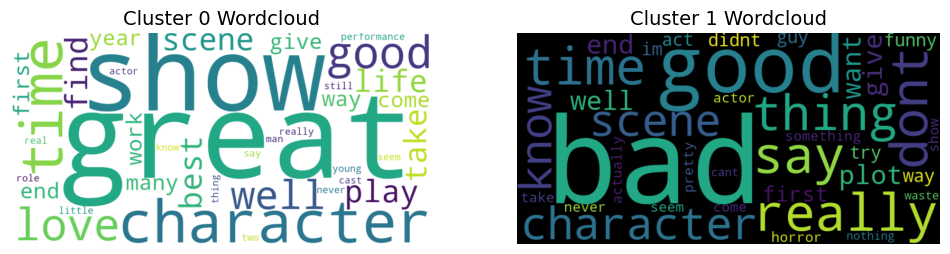

In [40]:
# Try K-means with nigram
X_tfidf = tfidf.fit_transform(data['review'])
kmeans = KMeans(n_clusters=2, random_state=43)
kmeans.fit(X_tfidf)
cluster_labels = kmeans.labels_

terms = tfidf.get_feature_names_out()
top_terms_per_cluster = {}

for cluster_idx, center in enumerate(kmeans.cluster_centers_):
    sorted_indices = np.argsort(center)[::-1][:40]
    top_terms_per_cluster[cluster_idx] = " ".join([terms[i] for i in sorted_indices])

# Visualize the result by wordcloud
wordcloud_cluster_0 = WordCloud(
    width=800, height=400, background_color='white', random_state=43).generate(top_terms_per_cluster[0])

wordcloud_cluster_1 = WordCloud(
    width=800, height=400, background_color='black', random_state=43).generate(top_terms_per_cluster[1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_cluster_0, interpolation='bilinear')
plt.title("Cluster 0 Wordcloud", fontsize=14)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cluster_1, interpolation='bilinear')
plt.title("Cluster 1 Wordcloud", fontsize=14)
plt.axis('off')

plt.show()

Cluster 0: 7938 reviews
Cluster 1: 4562 reviews


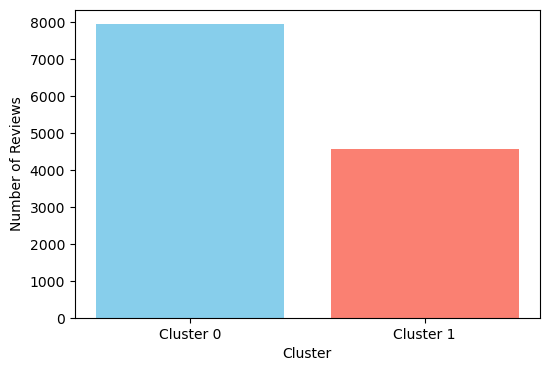

In [41]:
#Count the number of reviews in each cluster
cluster_counts = Counter(cluster_labels)
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} reviews")

clusters = list(cluster_counts.keys())
counts = list(cluster_counts.values())

plt.figure(figsize=(6, 4))
plt.bar(clusters, counts, color=['skyblue', 'salmon'])
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.xticks(clusters, [f"Cluster {c}" for c in clusters])

plt.show()

In [42]:
# Compare the 2 clusters with the original true labels to see the accuracy of K-means 
data['cluster'] = cluster_labels
data['cluster'] = data['cluster'].apply(lambda x: 1 if x == 0 else 0)

# Calculate the accuracy of K-means clustering
accuracy = accuracy_score(data['sentiment'], data['cluster'])
print(f"Accuracy of K-means clustering: {accuracy:.2f}")

Accuracy of K-means clustering: 0.70


In [43]:
# To reverse the cluster order to check whether cluster corresponds to the right label. Obviously the above one is correct,
# with accuracy of 70%, which is not so good as other models.
data['cluster'] = cluster_labels
data['cluster'] = data['cluster'].apply(lambda x: 0 if x == 0 else 1)

# Calculate the accuracy of K-means clustering
accuracy = accuracy_score(data['sentiment'], data['cluster'])
print(f"Accuracy of K-means clustering: {accuracy:.2f}")

Accuracy of K-means clustering: 0.30
